<a href="https://colab.research.google.com/github/Marei33/Deep-Learning/blob/main/Sol_Ex3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3 - CNNs, ResNets and LR-Scheduling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## General information
* Deep Learning – Winter term 2021/22
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Due date: **Tue, 07. Dec 21, at noon**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
import os

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [ ]:
# TODO import utils.py

from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils.py


## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [ ]:
# TODO define device
device = utils.get_device()
# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu
2 CPUs available


In [ ]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset, testset, dataset_mean, dataset_std = utils.grab_data(data_dir, num_cpus=2)
trainset, valset = utils.generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [ ]:
# TODO define loss function
loss_fn = torch.nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.


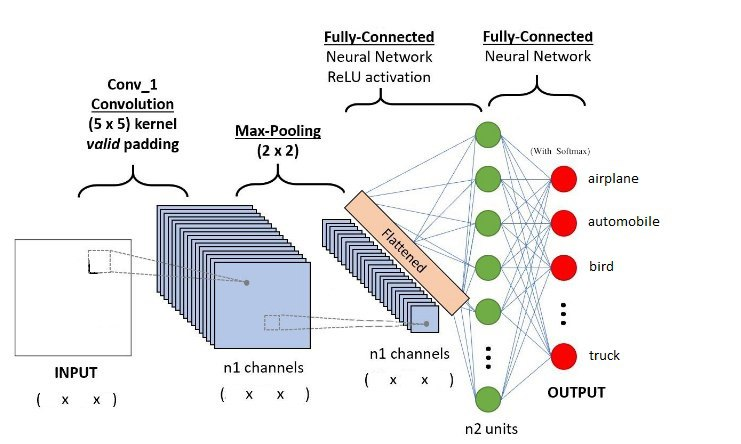

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

#### **Answers**

- Input dimensions: 32x32x3
- Feature maps dimensions: 32x28x28 --> M=(32-5)/1+1
- After pooling dimensions: 32x14x14 --> 28/2=14
- Values for n1 and n2: 6272, 6272 --> Flattened: 32 * 14 * 
14 **what is meant by n1 values?** n1=32; n2=512
- Number of parameters for conv_1: 3217184 --> 32 * 5 * 5 * 3 = 




In [ ]:
# TODO define model
class CNN(nn.Module):
  def __init__(self, num_channels):
    super(CNN, self).__init__()

    self.num_channels = num_channels

    self.conv_layer = nn.Conv2d(num_channels, 32, (5, 5))
    self.max_pool = nn.MaxPool2d(2,2)
    self.flatten = nn.Flatten()
    self.Linear = nn.Linear((14*14*32), 512)
    self.output = nn.Linear(512, 10)


  def forward(self, x):
    x = self.conv_layer(x)
    x = self.max_pool(x)
    x = F.relu(x)

    x = self.flatten(x)

    x = self.Linear(x)
    x = F.relu(x)

    x = self.output(x)
    return x

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

In [ ]:
def run_model(name, model, num_channels=3, loss_function=loss_fn, lr=1e-3, num_epochs=10, patience=None):

  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model, optimizer, loss_function, device, num_epochs, 
                                                                                  trainloader, valloader, early_stopper=patience, verbose=False)

  best_loss_value = np.array(val_losses).min()
  best_loss_epoch = np.array(val_losses).argmin()
  best_acc_value = np.array(val_accs).max()
  best_acc_epoch = np.array(val_accs).argmax()

  print("Lowest  validation loss:     {} (in epoch {})".format(best_loss_value, best_loss_epoch))
  print("Highest validation accuracy: {} (in epoch {})".format(best_acc_value, best_acc_epoch))

  utils.plot("Converged Model Losses", "Epochs", train_losses, val_losses, yscale='linear', save_path=None, extra_pt="Loss", extra_pt_label=None)
  utils.plot("Converged Model Accuracy", "Epochs", train_accs, val_accs, yscale='linear', save_path=None, extra_pt="Accuracy", extra_pt_label=None)

  torch.save(model.state_dict(), name)

Finished training after 152 seconds.
Lowest  validation loss:     1.000497305393219 (in epoch 9)
Highest validation accuracy: 0.659 (in epoch 9)


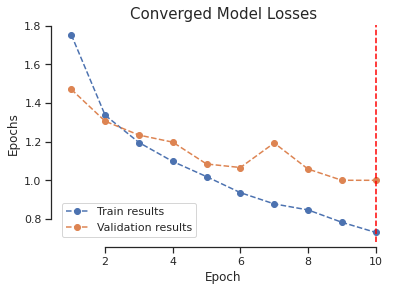

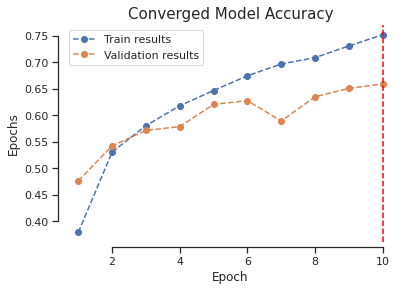

In [ ]:
# TODO train and plot
model = CNN(num_channels=3)
run_model("CNN_1", model=model)

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**: 
Even after merely 10 epochs, which clearly hasn't lead the cnn model to converge, the cnn model is already more accurate in the validation set than the mlp model after it has converged.

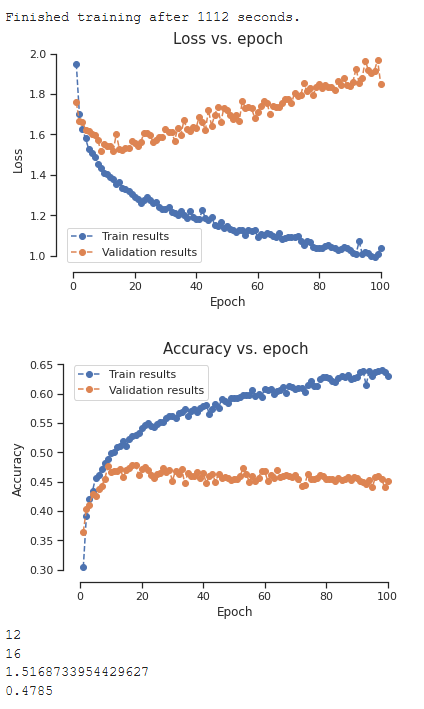

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 922 seconds.
Lowest  validation loss:     1.0046696841716767 (in epoch 11)
Highest validation accuracy: 0.6761 (in epoch 39)


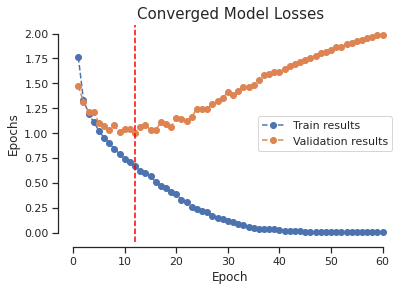

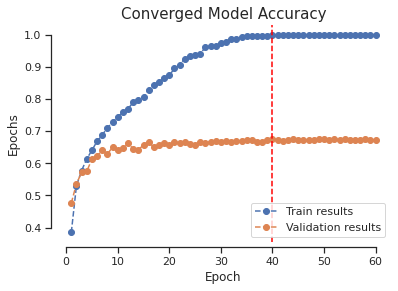

In [ ]:
# TODO train and plot
run_model("CNN_2", model=model, num_epochs=60)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**: when high val_accuracy, higher val loss: overfitting! Learning rate anpassen; Early Stopping

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

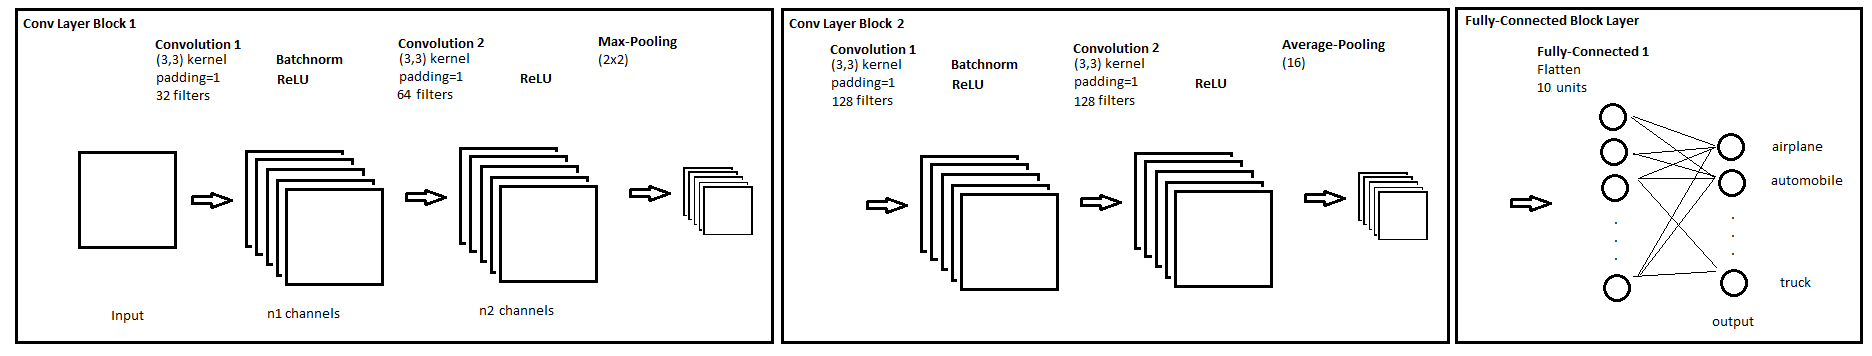

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**
*   Padding: type "same": add zeros around the feature maps, to get the same input and output dimension; type "valid": feature maps shrinks by k-1 pixels after each convolution with kxk kernel
*   padding = 1 ("same"): because a 3x3 kernel is used, the dimensions of the input and output feature maps stay the same
* Conv layer 1: 32 x 32 x 32
* Conv layer 2: 32 x 32 x 64
* receptive field after first two conv: 1+(3-1)+(3-1) = 5; 5 x 5
* input dimension for fully connected layer: 128
* number of parameters first conv layer block: 32 x 3 x 3 x 3 + 64 x  3 x 3 x 32 = 19,296



In [ ]:
#TODO define model 2
class bigger_CNN(nn.Module):
  def __init__(self, num_channels):
    super(bigger_CNN, self).__init__()

    self.num_channels = num_channels

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(num_channels, 32, (3, 3), 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, (3, 3), 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64, 128, (3,3), 1, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3,3), 1, 1),
        nn.ReLU(),
        nn.AvgPool2d(16)
    )

    self.fully_connected = nn.Sequential(
        nn.Flatten(),
        nn.Linear(128, 10)
    )


  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.fully_connected(x)

    return x

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 12665 seconds.
Lowest  validation loss:     0.9931668996810913 (in epoch 26)
Highest validation accuracy: 0.6511 (in epoch 26)


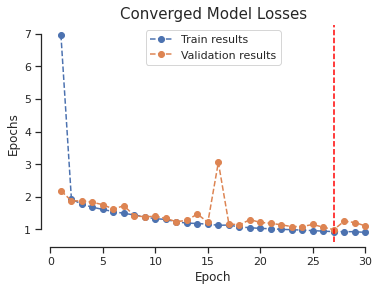

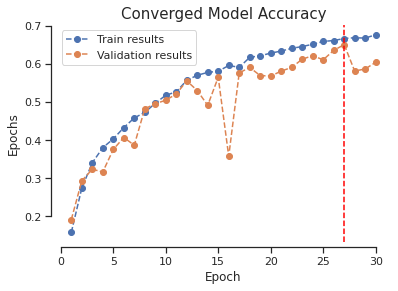

In [ ]:
# TODO train and plot
model = bigger_CNN(num_channels=3)

run_model("biggerCNN1", model=model, num_epochs=30, lr=1e-1)

**Explanation:** CNN deeper, better results, but longer training; jetzt schon gleich gute val_accuracy wie vorher bei kleinem CNN und 60 Epochen; wird nicht direkt overfitted

In [ ]:
run_model("biggerCNN2", model=model, num_epochs=30, lr=1e-3)

KeyboardInterrupt: ignored

In [ ]:
run_model("biggerCNN3", model=model, num_epochs=30, lr=1e-4)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

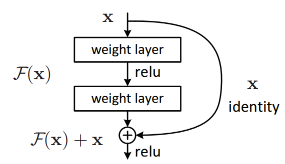

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**


* solves the problem of vanishing gradients
* In a traditional network the layers are learning the true output H(x), whereas in the layers in a residual network are learning the residuals by the skipped connections H(x)+x. That is why it is called residual net. 
* advantage? when using really deep nets



#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

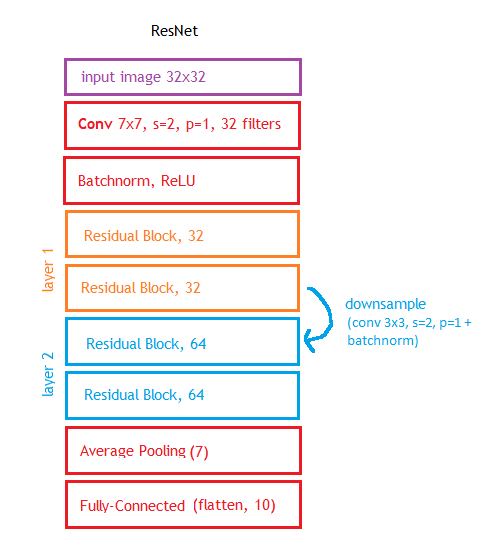 
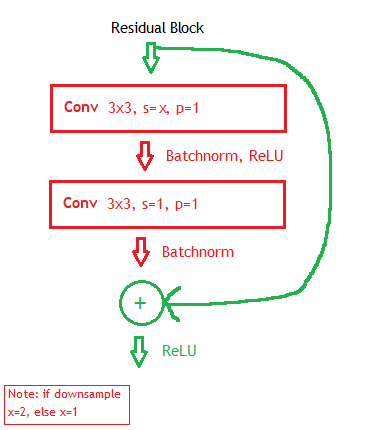

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet
class ResidualBlock(nn.Module):
  def __init__(self, num_channels):
    super().__init__()
    self.num_channels = num_channels
    self.conv1 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
    self.conv2 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(num_channels)
    self.batchnorm2 = nn.BatchNorm2d(num_channels)

  def convblock(self, x):
    x = F.relu(self.batchnorm1(self.conv1(x)))
    x = self.batchnorm2(self.conv2(x))
    return x

  def forward(self, x):
    return x + self.convblock(x)


In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model
class ResNet(nn.Module):
  def __init__(self, num_channels=32):
    super(ResNet, self).__init__()

    self.num_channels = num_channels

    self.conv_block = nn.Sequential(
        nn.Conv2d(num_channels, 32, (7,7), 2, 1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    
    self.res_layer1 = ResidualBlock(32)

    self.downsample = nn.Sequential(
        nn.Conv2d(32, 64, (3,3), 2, 1),
        nn.BatchNorm2d(64)
    )

    self.res_layer2 = ResidualBlock(64)

    self.avg_pool = nn.AvgPool2d(7)

    self.fully_connected = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    x = self.conv_block(x)
    x = self.res_layer1(x)
    x = self.downsample(x)
    x = self.res_layer2(x)
    x = self.avg_pool(x)
    x = self.fully_connected(x)

    return x


Finished training after 708 seconds.
Lowest  validation loss:     1.0660513758659362 (in epoch 8)
Highest validation accuracy: 0.6211 (in epoch 8)


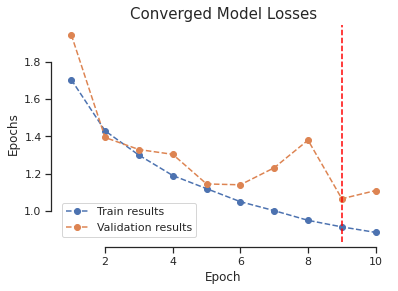

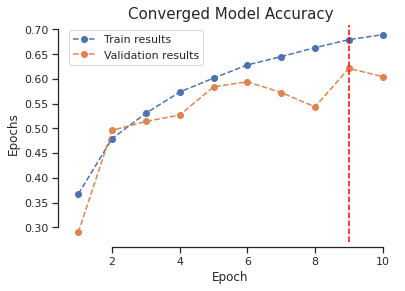

In [ ]:
# TODO train and plot

model = ResNet(num_channels = 3)

run_model("ResNet", model=model)

In [ ]:
run_model("ResNet_2", model=model, num_epochs=30)

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

# Adding Scheduling to the input of running the training ######################################################## 
def run_training(model, optimizer, scheduler, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]


    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = utils.train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        
        # Step for the sheduler after each epoch ######################################################## 
        scheduler.step()

        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = utils.validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            ####################
            ## YOUR CODE HERE ##
            ####################
            #raise NotImplementedError

            # Initialize the early stopper in the first epoch:
            # Otherwise give new information, e.g. current epoch accuracy and model, to the EarlyStopper:
            if epoch == 0:
              #print("Initializing the EarlyStopper")
              ES = EarlyStopper(val_accs, model, patience=early_stopper, verbose=False, path='checkpoint.pt')
            else:
              #print("Updating the EarlyStopper")
              ES.update(val_accs, model)

            # Check if the early stop criterion is reached
            if ES.early_stop == True:
              print("Early stopping, since the validation accuracy did not increase. Epoch: {}".format(epoch))
              break
            else:
              continue

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix



In [ ]:
def run_model(name, model, num_channels=3, loss_function=loss_fn, lr=1e-3, step_size=1, gamma=0.1, num_epochs=10, patience=None):

  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Adding Learning Rate Scheduling ######################################################## 
  scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

  # Passing Scheduling to the run_training function ######################################################## 
  train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, scheduler, loss_function, device, num_epochs, 
                                                                                  trainloader, valloader, early_stopper=patience, verbose=False)

  best_loss_value = np.array(val_losses).min()
  best_loss_epoch = np.array(val_losses).argmin()
  best_acc_value = np.array(val_accs).max()
  best_acc_epoch = np.array(val_accs).argmax()

  print("Lowest  validation loss:     {} (in epoch {})".format(best_loss_value, best_loss_epoch))
  print("Highest validation accuracy: {} (in epoch {})".format(best_acc_value, best_acc_epoch))

  utils.plot("Converged Model Losses", "Epochs", train_losses, val_losses, yscale='linear', save_path=None, extra_pt="Loss", extra_pt_label=None)
  utils.plot("Converged Model Accuracy", "Epochs", train_accs, val_accs, yscale='linear', save_path=None, extra_pt="Accuracy", extra_pt_label=None)

  torch.save(model.state_dict(), name)

Finished training after 713 seconds.
Lowest  validation loss:     1.4104614496231078 (in epoch 8)
Highest validation accuracy: 0.497 (in epoch 7)


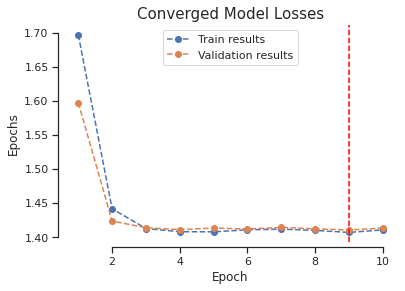

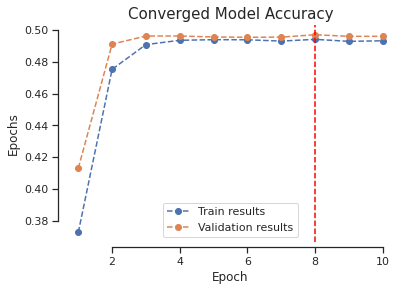

In [ ]:
# TODO train and plot with step size 1, gamma 0.1
model = ResNet(num_channels = 3)

run_model("ResNet", model=model, step_size=1, gamma=0.1)

In [ ]:
# TODO train and plot with step size 1, gamma 0.9
model = ResNet(num_channels = 3, step_size=1, gamma=0.9)

run_model("ResNet", model=model)

TypeError: ignored

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10